## Bottom DO

A simple notebook to generate dissolved oxygen plots for the bottom layer, either for a single run or to compare multiple runs side-by-side.

## Parameters

* `do_data_cdf`: The NetCDF file containing DO results. This is generated using one of the extraction notebooks or [rawcdf_extract.py](rawcdf_extract.py).
* `do_variables`: The NetCDF variable names to output. The first variable will be treated as a control which other runs are compared against on the comparison plots.
* `control_variable`: The name of the variable that represents a control run.
* `variable_type`: The variable suffix added from [rawcdf_extract.py](rawcdf_extract.py), usually `DOXG_bottom` but it could be something else.
* `out_path`: Custom output location for saved figures, spreadsheets, and shapefiles.
* `start_date`: A date string to use as day 0 when formatting plot time axes. This is only needed if the start date isn't in the extraction file; recent versions of rawcdf_extract.py include it.
* `grid_file`: The 2-D mesh file defining the SSM grid. The analysis domain is a subsection of this grid, which is read from the DO result NetCDF file above.
* `sites`: A dict of node numbers and corresponding labels for locations that get dedicated timeseries plots of bottom DO.

In [1]:
do_data_cdf = "model_results/bottom do 2008.nc"
do_variables = ('reference','existing')
control_variable = 'reference'
variable_type = 'DOXG_bottom'
out_path = 'notebook_outs/bottom_do_2008'

start_date = "2008-01-01"
grid_file = 'SSM_Grid/ssm_grid.2dm'

sites = {
    7786: "Admiralty Inlet South",
    12166: "East Passage",
    15490: "Budd Inlet",
    13789: "Lynch Cove"
}

from pathlib import Path
import os.path as path
import os
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import cmocean
import matplotlib.colors as colors

from fvcom.grid import FvcomGrid
from fvcom.control_volume import ControlVolume, StationHelper

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), node(3164)
    variables(dimensions): int32 node(node), int32 h(node), int32 x(node), int32 y(node), float32 time(time), float32 existingDOXG_bottom(time, node), float32 referenceDOXG_bottom(time, node)
    groups: 

Determine the timestep of the output (needed for hypoxic duration calculations later)

In [3]:
if 'model_start' in do_data.ncattrs():
    start_date = pd.Timestamp(do_data.model_start)
    display(f'Model start date is {start_date}')
else:
    start_date = pd.Timestamp(start_date)
timestep = do_data['time'][2] - do_data['time'][1]
timestep

np.float32(0.041666668)

Some basic sanity checks on input values from the first cell

In [4]:
for n in sites.keys():
    assert n in do_data['node'][:], f"Node number {n} is not present in the file. Pick a different site."
if type(do_variables) == str:
    do_variables = (do_variables,)
control_variable += variable_type if not control_variable.endswith(variable_type) else ''
do_variables = [v + (variable_type if not v.endswith(variable_type) else '') for v in do_variables]
assert control_variable in do_variables, f"Control variable '{control_variable}' should be present in do_variables."

Determine the name to use for output files.

All outputs will be in the `notebook_outs` directory. They will start with the base name (without extension) of the given NetCDF file, followed by `_botdo_`, then a descriptive name of the output.

In [5]:
out_base = Path(do_data_cdf).stem
if not path.isdir(out_path):
    os.mkdir(out_path)
out_base = Path(do_data_cdf).stem
out_file = lambda name: path.join("notebook_outs", out_base + "_botdo_" + name)

Remove any 'DOXG_bottom" suffixes for friendlier plot titles

In [6]:
do_variable_titles = [s.removesuffix(variable_type) for s in do_variables]
control_title = control_variable.removesuffix(variable_type)
if variable_type == 'DOXG_bottom':
    variable_type_name = 'Bottom'
elif variable_type == 'DOXG_min':
    variable_type_name = 'Minimum'
print(f'Control is {control_title}')
do_variable_titles

Control is reference


['reference', 'existing']

In [7]:
grid = FvcomGrid.from_mesh(grid_file)
cv = ControlVolume(grid=grid, nodes=set(do_data['node'][:]), calc=True)
domain = cv.tces
domain.head()

,geometry
4369,"POLYGON ((515281.5 5333310.5, 515468 5332882, ..."
4370,"POLYGON ((515087 5334737.5, 515315 5334346.333..."
4371,"POLYGON ((515719.5 5336024, 515768 5335644.667..."
4372,"POLYGON ((516396.667 5336859, 516797.5 5336642..."
4373,"POLYGON ((517117.667 5338020.667, 517569 53377..."


# Bottom DO for Selected Sites

Produce a timeseries of bottom DO at each of the sites defined in the `sites` variable, along with a corresponding Excel workbook that contains one sheet per site.

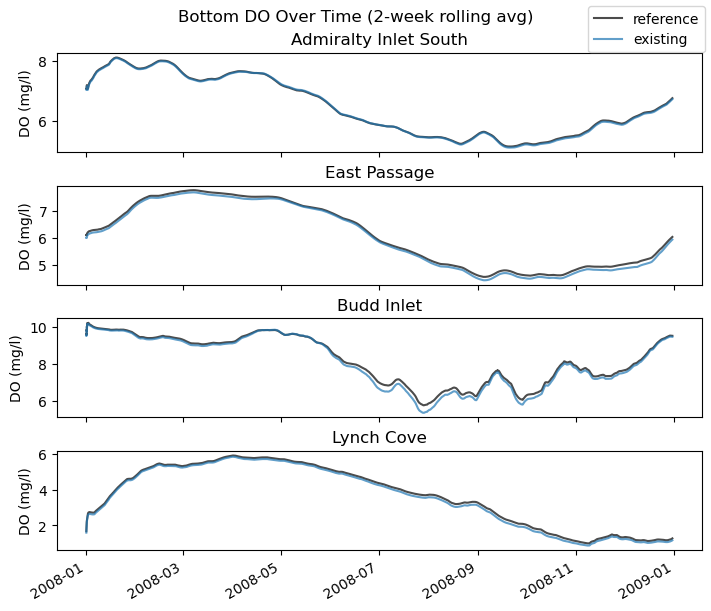

In [8]:
times = do_data['time'][:]
dates = start_date + pd.to_timedelta(times, 'd')
if len(sites):
    fig, axs = plt.subplots(len(sites), 1, constrained_layout=True, figsize=(7, int(1.5*len(sites))), dpi=100)
    with pd.ExcelWriter(out_file("sites.xlsx")) as writer:
        # Iterate over all the specified sites, along with a dedicated plot Axes per site
        for ax,(n,s) in zip(axs, sites.items()):
            #tsax, boxax = ax
            tsax = ax
            idx = np.nonzero(do_data['node'][:] == n)[0][0]
            data = None
            lbl = "{0} ({1})".format(s, n)
            # Plot all the required variables on this Axes
            for v, t in zip(do_variables, do_variable_titles):
                if data is None:
                    data = pd.DataFrame({t: do_data[v][:,idx] }, index=dates)
                else:
                    data[t] = do_data[v][:,idx]
                if t == control_title:
                    color = 'black'
                else:
                    color = None
                data[t].rolling('14D').mean().plot(color=color, alpha=0.7, ax=tsax)
            tsax.set(title=s, ylabel="DO (mg/l)")
    
            #boxax.boxplot(data.values(), labels=data.keys())
    
            data.to_excel(writer, sheet_name=lbl)
    
    # Implement autofmt_xdate() by hand because it breaks subplot title placement
    # Turn off xaxis labels on all but the last Axes
    for ax in axs[:-1]:
        ax.set_xticklabels(())
    # Orient the date labels properly on the lowest Axes
    for l in axs[-1].get_xticklabels():
        l.set_ha('right')
        l.set_rotation(30)
    
    fig.suptitle(f"{variable_type_name} DO Over Time (2-week rolling avg)")
    # One common legend. https://stackoverflow.com/a/46921590/413862
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    fig.savefig(out_file("sites.png"))

## Hypoxia

Pre-calculate the hypoxic durations and areas for each variable. If masking is enabled, this takes a while because of the indexer on the NetCDF dataset.

In [9]:
# Representative areas of each node in km2
areas = domain.area / 1e6
# Total area in km2
total_area = cv.area

def extract_data(var):
    return do_data[var][:].data

# Calculate the total time that this retrieved node index spent with a hypoxic DO
def calc_duration(data, i):
    return np.count_nonzero(data[:,i] < 2) * timestep

def calc_area(data, t):
    return areas.loc[data[t,:] < 2].sum()

extracted_data = {}
hypoxic_durations = {}
hypoxic_areas = {}
max_duration = 0

for v in do_variables:
    extracted_data[v] = extract_data(v)
    hypoxic_durations[v] = np.zeros(extracted_data[v].shape[1])
    for n in range(len(hypoxic_durations[v])):
        hypoxic_durations[v][n] = calc_duration(extracted_data[v], n)
    max_duration = max(max_duration, hypoxic_durations[v].max())
    hypoxic_areas[v] = np.zeros(extracted_data[v].shape[0])
    for t in range(len(hypoxic_areas[v])):
        hypoxic_areas[v][t] = calc_area(extracted_data[v], t)

# Assemble a DataFrame of all the hypoxic area timeseries for each variable
hypoxic_areas_df = pd.DataFrame(hypoxic_areas, index=dates)

print("Max hypoxic duration: {:.2f} days".format(max_duration))
hypoxic_areas_df.head()

Max hypoxic duration: 141.75 days


,referenceDOXG_bottom,existingDOXG_bottom
2008-01-01 00:00:00.000000000,12.829966,13.304291
2008-01-01 01:00:00.000107285,12.339261,12.554145
2008-01-01 02:00:00.000214580,12.339261,12.554145
2008-01-01 03:00:00.000000000,10.999674,11.834250
2008-01-01 04:00:00.000429151,7.587637,8.654037


## Hypoxic Duration

Create one plot per DO variable showing the hypoxic duration in days for each node. Also generates an ESRI shapefile that can be loaded into GIS software with the same information, and an Excel spreadsheet.

ERROR 1: PROJ: proj_create_from_database: Open of /home/benr/mambaforge/envs/ssm-analysis/share/proj failed


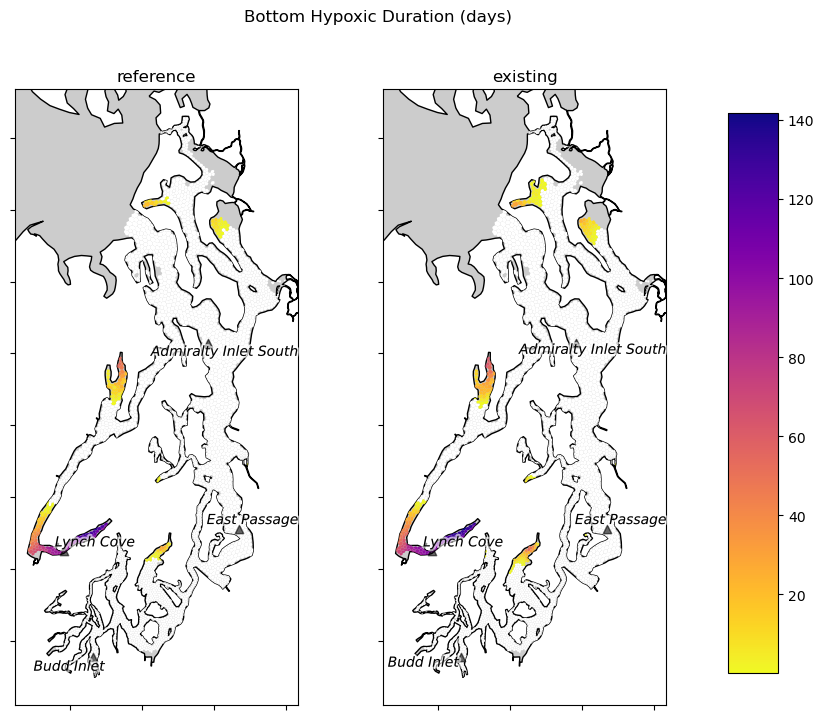

In [10]:
mycmap = cm.get_cmap("plasma_r").copy()
mycmap.set_under('white', 1)

fig, axs = plt.subplots(1, len(do_variables), figsize=(5*len(do_variables), 8))
# For compatibility in the case that there's only a single plot to make
if len(do_variables) == 1:
    axs = np.array([axs])

# Normalize all the durations so the colors match between the plots
norm_duration = colors.Normalize(vmin=0.1, vmax=max_duration)
station_helper = StationHelper(sites)

# Make a map of the durations for each variable, assembling them into one single
# GeoDataFrame for output
data = cv.tces
data.index.name = 'node_id'
for ax, v, t in zip(axs, do_variables, do_variable_titles):
    if ax == axs[-1]:
        # See https://stackoverflow.com/a/13784887/413862 and
        # https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        legend_args = { "legend": True, "cax": cbar_ax }
    else:
        legend_args = { "legend": False }
    cv.plot(data=hypoxic_durations[v], ax=ax, cmap=mycmap, norm=norm_duration,
            helpers=[station_helper], **legend_args)
    ax.set(title=t, xticklabels=(), yticklabels=())
    data[t] = hypoxic_durations[v]
        
fig.suptitle(f"{variable_type_name} Hypoxic Duration (days)")

fig.savefig(out_file("hypox_duration.png"))
data.to_file(out_file("hypox_duration.shp"))
data['node_area_km2'] = data['geometry'].area / 1e6
data.to_excel(out_file("hypox_duration.xlsx"))

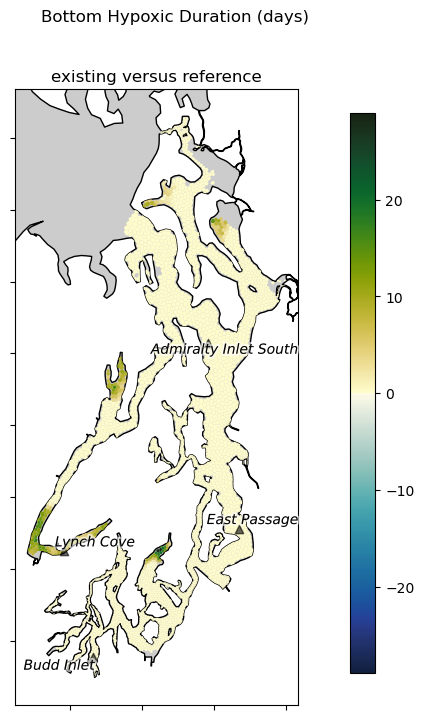

In [11]:
if control_variable is not None and len(do_variables) > 1:
    exp_variables = []
    exp_titles = []
    control_title = do_variable_titles[do_variables.index(control_variable)]
    for v in do_variables:
        if v == control_variable:
            continue
        exp_variables.append(v)
        t = do_variable_titles[do_variables.index(v)]
        exp_titles.append(f'{t} versus {control_title}')
else:
    exp_variables = None

if exp_variables is not None:
    duration_diffs = [hypoxic_durations[v] - hypoxic_durations[control_variable] for v in exp_variables]

    fig, axs = plt.subplots(1, len(do_variables) - 1, figsize=(5*(len(do_variables) - 1), 8))

    # For compatibility in the case that there's only a single plot to make
    if len(do_variables) == 2:
        axs = np.array([axs])
    
    divnorm = colors.CenteredNorm(halfrange=np.max(np.abs(duration_diffs)))

    # Make a map of the duration difference between each variable and the control
    for ax, v, t in zip(axs, duration_diffs, exp_titles):
        if ax == axs[-1]:
            # See https://stackoverflow.com/a/13784887/413862 and
            # https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            legend_args = { "legend": True, "cax": cbar_ax }
        else:
            legend_args = { "legend": False }
        cv.plot(data=v, ax=ax, cmap=cmocean.cm.delta, norm=divnorm,
                helpers=[station_helper], **legend_args)
        ax.set(title=t, xticklabels=(), yticklabels=())
            
fig.suptitle(f"{variable_type_name} Hypoxic Duration (days)")
fig.savefig(out_file("hypox_duration_compare.png"))

## Hypoxic Area

Generate a timeseries plot of each DO variable's total hypoxic area over the runtime of the model, plus an Excel spreadsheet containing the timeseries data.

reference: Max hypoxic area 66.94 km2 on 2008-12-23
existing: Max hypoxic area 76.08 km2 on 2008-09-24


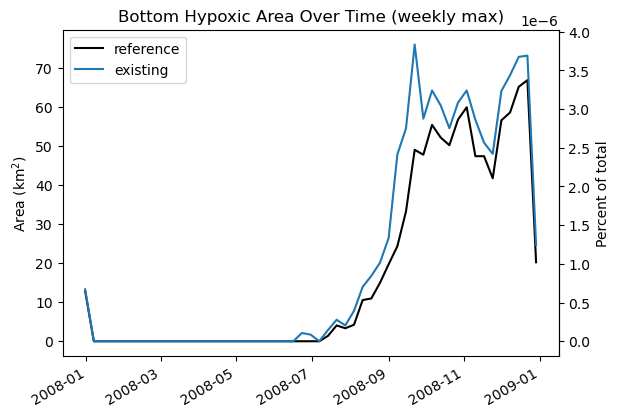

In [12]:
# Plot each DF column and print the maximum value
fig, ax = plt.subplots()
hypoxic_areas_weekly = hypoxic_areas_df.groupby(hypoxic_areas_df.index.to_period('W')).max()
hypoxic_areas_weekly.set_index(hypoxic_areas_weekly.index.to_timestamp('D', 's'), inplace=True)
for v, t in zip(do_variables, do_variable_titles):
    if t == control_title:
        color = 'black'
    else:
        color = None
    ax.plot(hypoxic_areas_weekly[v], color=color, label=t)
    print("{0}: Max hypoxic area {1:.2f} km2 on {2}".format(t, hypoxic_areas_df[v].max(),
                                                            hypoxic_areas_df[v].idxmax().date()))
ax.set(title=f"{variable_type_name} Hypoxic Area Over Time (weekly max)", ylabel="Area (km$^2$)")
fig.autofmt_xdate()
ax.legend()

# Build a secondary y-axis with the total area percentage
def area_to_pct(a):
    return a * 100 / total_area
def pct_to_area(p):
    return p / 100 * total_area

secax = ax.secondary_yaxis('right', functions=(area_to_pct, pct_to_area))
secax.set_ylabel("Percent of total")

fig.savefig(out_file("hypoxic_area.png"))
hypoxic_areas_df.to_excel(out_file("hypoxic_area.xlsx"))

## Low DO Comparison

Compare DOmin and DO at the 0.1 quantile

/tmp/ipykernel_2227430/3696162722.py:40: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data.to_file(out_file(f'do_{qdesc}.shp'))
/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'referenceDOXG_bottom' to 'referenceD'
  ogr_write(
/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'existingDOXG_bottom' to 'existingDO'
  ogr_write(
/tmp/ipykernel_2227430/3696162722.py:40: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data.to_file(out_file(f'do_{qdesc}.shp'))
/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'referenceDOXG_bottom' to 'referenceD'
  ogr_write(
/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-p

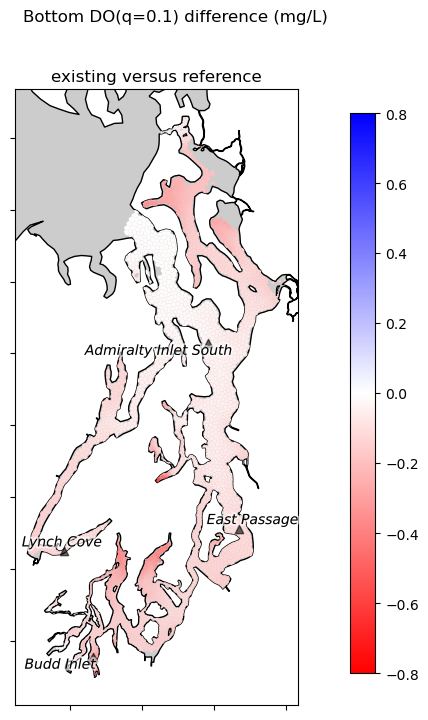

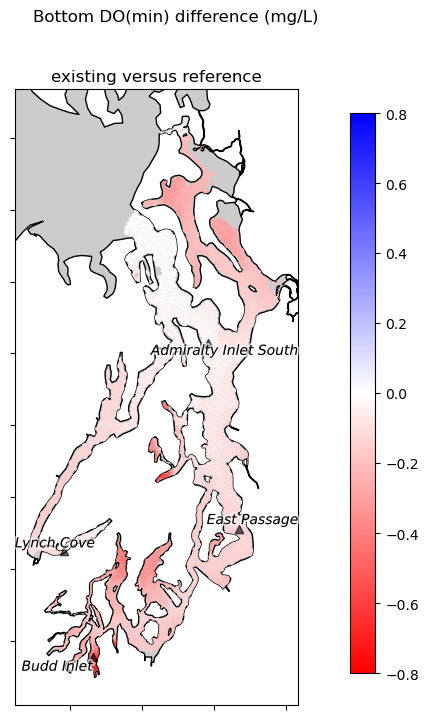

In [13]:
def plot_quantile(q):
    qdesc = f'q={q}' if q > 0 else 'min'

    control = np.quantile(extracted_data[control_variable], q, axis=0)
    vals = [np.quantile(extracted_data[v], q, axis=0) for v in exp_variables]

    fig, axs = plt.subplots(1, len(exp_variables), figsize=(5*len(exp_variables), 8))

    #norm_do = colors.Normalize(vmin=np.min(vals - control), vmax=np.max(vals - control))
    #norm_do = colors.CenteredNorm(halfrange=max(np.max(vals - control), -1*np.min(vals - control)))
    norm_do = colors.CenteredNorm(halfrange=0.8)
    
    # For compatibility in the case that there's only a single plot to make
    if len(vals) == 1:
        axs = np.array([axs])

    # Make a map of this quantile for each variable compared to the control, assembling
    # them into one single GeoDataFrame for output
    for ax, v, t in zip(axs, vals, exp_titles):
        if ax == axs[-1]:
            # See https://stackoverflow.com/a/13784887/413862 and
            # https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            legend_args = { "legend": True, "cax": cbar_ax }
        else:
            legend_args = { "legend": False }
        cv.plot(data=v-control, ax=ax, cmap='bwr_r', norm=norm_do,
                helpers=[station_helper], **legend_args)
        ax.set(title=t, xticklabels=(), yticklabels=())
    data = domain.copy()
    data.index.name = 'node_id'
    data[control_variable] = control
    for v, t in zip(vals, exp_variables):
        data[t] = v

    fig.suptitle(f'{variable_type_name} DO({qdesc}) difference (mg/L)')

    fig.savefig(out_file(f'do_{qdesc}.png'))
    data.to_file(out_file(f'do_{qdesc}.shp'))
    data['node_area_km2'] = data['geometry'].area / 1e6
    data.to_excel(out_file(f'do_{qdesc}.xlsx'))

if exp_variables is not None:
    plot_quantile(0.1)
    plot_quantile(0)

In [14]:
do_data.close()